In [105]:
import numpy as np
import random
import datetime
import time
import os
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast

import argparse
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader

from ember_utils import *
from ember_model import *
from ember_pjr_utils import *

In [106]:
def create_parent_folder(file_path):
    if not os.path.exists(os.path.dirname(file_path)):
        os.makedirs(os.path.dirname(file_path))



def get_family_labeled_month_data(data_dir, month, train=True):
    
    if train:
        data_dir = data_dir + str(month) + '/'
        XY_train = np.load(data_dir + 'XY_train.npz')
        X_tr, Y_tr, Y_tr_family = XY_train['X_train'], XY_train['Y_train'], XY_train['Y_family_train']

        print(f'X_train {X_tr.shape} Y_train {Y_tr.shape} Y_tr_family {Y_tr_family.shape}')
        
        return X_tr, Y_tr, Y_tr_family
    else:
        data_dir = data_dir + str(month) + '/'
        XY_test = np.load(data_dir + 'XY_test.npz')
        X_test, Y_test, Y_test_family = XY_test['X_test'], XY_test['Y_test'], XY_test['Y_family_test']

        return X_test, Y_test, Y_test_family

    
    
def get_family_labeled_task_test_data(data_dir, task_months, mlp_net=False):
    
    X_te, Y_te, Y_te_family = get_family_labeled_month_data(data_dir, task_months[-1], train=False)
    
    for month in task_months[:-1]:
        pre_X_te, pre_Y_te, pre_Y_te_family = get_family_labeled_month_data(data_dir, month, train=False)
        X_te, Y_te, Y_te_family = np.concatenate((X_te, pre_X_te)), np.concatenate((Y_te, pre_Y_te)),\
                                np.concatenate((Y_te_family, pre_Y_te_family))
        

    X_test, Y_test, Y_test_family = X_te, Y_te, Y_te_family
    print(f'X_test {X_test.shape} Y_test {Y_test.shape} Y_te_family {Y_te_family.shape}')
    
    return X_test, Y_test, Y_test_family



def make_family_based_dict(X_train, Y_train, Y_train_family, task_month, global_family_dict):
    count = 0
    for x_ind, x_sample in enumerate(X_train):
        count += 1
        #print(x_ind, Y_train[x_ind])

        if Y_train[x_ind] == 0:
            global_family_dict["goodware"].append(x_sample)
        if Y_train[x_ind] == 1:
            if Y_train_family[x_ind] == '':
                global_family_dict["others_family"].append(x_sample)
            else:
                global_family_dict[Y_train_family[x_ind]].append(x_sample)

    print(f'Task {task_month} and #-of new samples stored {count}')
    
    return global_family_dict



def get_replay_samples(global_family_dict, num_samples_per_malware_family):
    pre_malware_samples = []

    cnt = 0
    for k in global_family_dict.keys():
        if k != 'goodware':
            cnt += 1
            if num_samples_per_malware_family > len(global_family_dict[k]):
                selected_family_samples = random.sample(global_family_dict[k], len(global_family_dict[k]))
            else:
                selected_family_samples = random.sample(global_family_dict[k], num_samples_per_malware_family)

            #print(selected_family_samples)
            for sample in selected_family_samples:
                pre_malware_samples.append(sample)
                
    if len(global_family_dict['goodware']) < len(pre_malware_samples):
        pre_goodware_samples = random.sample(global_family_dict['goodware'], len(global_family_dict['goodware']))
    else:
        pre_goodware_samples = random.sample(global_family_dict['goodware'], len(pre_malware_samples))

    samples_to_replay = np.concatenate((np.array(pre_goodware_samples), np.array(pre_malware_samples)))
    labels_to_replay = np.concatenate((np.zeros(len(pre_goodware_samples)), np.ones(len(pre_malware_samples))))


    print(f'X_replay {samples_to_replay.shape} Y_replay {labels_to_replay.shape}')
    print(f'Replay {len(pre_malware_samples)} malware samples of {len(global_family_dict.keys()) -1} families')
    print(f'and Replay {len(pre_goodware_samples)} goodware samples')
    
    
    return samples_to_replay, labels_to_replay




def get_replay_samples_first(global_family_dict, num_samples_per_malware_family):
    pre_malware_samples = []

    cnt = 0
    for k in global_family_dict.keys():
        if k != 'goodware':
            cnt += 1
            if num_samples_per_malware_family > len(global_family_dict[k]):
                selected_family_samples = global_family_dict[k] 
                #random.sample(global_family_dict[k], len(global_family_dict[k]))
            else:
                selected_family_samples = global_family_dict[k][:num_samples_per_malware_family]
                #random.sample(global_family_dict[k], num_samples_per_malware_family)

            #print(selected_family_samples)
            for sample in selected_family_samples:
                pre_malware_samples.append(sample)
                
    if len(global_family_dict['goodware']) < len(pre_malware_samples):
        pre_goodware_samples = global_family_dict['goodware'] 
        #random.sample(global_family_dict['goodware'], len(global_family_dict['goodware']))
    else:
        pre_goodware_samples = global_family_dict['goodware'][:len(pre_malware_samples)] 
        #random.sample(global_family_dict['goodware'], len(pre_malware_samples))

    samples_to_replay = np.concatenate((np.array(pre_goodware_samples), np.array(pre_malware_samples)))
    labels_to_replay = np.concatenate((np.zeros(len(pre_goodware_samples)), np.ones(len(pre_malware_samples))))


    print(f'X_replay {samples_to_replay.shape} Y_replay {labels_to_replay.shape}')
    print(f'Replay {len(pre_malware_samples)} malware samples of {len(global_family_dict.keys()) -1} families')
    print(f'and Replay {len(pre_goodware_samples)} goodware samples')
    
    
    return samples_to_replay, labels_to_replay


def get_replay_samples_last(global_family_dict, num_samples_per_malware_family):
    pre_malware_samples = []

    cnt = 0
    for k in global_family_dict.keys():
        if k != 'goodware':
            cnt += 1
            if num_samples_per_malware_family > len(global_family_dict[k]):
                selected_family_samples = global_family_dict[k] 
                #random.sample(global_family_dict[k], len(global_family_dict[k]))
            else:
                selected_family_samples = global_family_dict[k][-num_samples_per_malware_family:]
                #random.sample(global_family_dict[k], num_samples_per_malware_family)

            #print(selected_family_samples)
            for sample in selected_family_samples:
                pre_malware_samples.append(sample)
                
    if len(global_family_dict['goodware']) < len(pre_malware_samples):
        pre_goodware_samples = global_family_dict['goodware']
        #random.sample(global_family_dict['goodware'], len(global_family_dict['goodware']))
    else:
        pre_goodware_samples = global_family_dict['goodware'][-len(pre_malware_samples):]
        #random.sample(global_family_dict['goodware'], len(pre_malware_samples))

    samples_to_replay = np.concatenate((np.array(pre_goodware_samples), np.array(pre_malware_samples)))
    labels_to_replay = np.concatenate((np.zeros(len(pre_goodware_samples)), np.ones(len(pre_malware_samples))))


    print(f'X_replay {samples_to_replay.shape} Y_replay {labels_to_replay.shape}')
    print(f'Replay {len(pre_malware_samples)} malware samples of {len(global_family_dict.keys()) -1} families')
    print(f'and Replay {len(pre_goodware_samples)} goodware samples')
    
    
    return samples_to_replay, labels_to_replay


In [109]:
def get_only_av_class_labeled_samples(all_X, all_Y, Y_Family):
    
    new_X = []
    new_Y = []
    new_Y_family = []
    
    for ind, y in enumerate(all_Y):
        if y == 1:
            if Y_Family[ind] != '':
                new_Y.append(y)
                new_X.append(all_X[ind])
                new_Y_family.append(Y_Family[ind])
        else:
            new_Y.append(y)
            new_X.append(all_X[ind])
            new_Y_family.append(Y_Family[ind])
            
            
    print(len(all_Y==1) == (len(new_Y) + (len(all_Y) - len(new_Y))))  
    print(len(new_X) == len(new_Y))
    
    new_X, new_Y, new_Y_family = np.array(new_X), np.array(new_Y), np.array(new_Y_family)
    return new_X, new_Y, new_Y_family


def getNOAVCLASS_partial_data(X, Y, Y_fam , replay_portion):
    indx = [i for i in range(len(Y))]
    random.shuffle(indx)

    replay_data_size = int(len(indx)*replay_portion)
    replay_index = indx[:replay_data_size]

    X_train = X[replay_index]
    Y_train = Y[replay_index]
    Y_family = Y_fam[replay_index]
    
    return X_train, Y_train, Y_family        
        
def getNOAVCLASS_PJR_random_training_data(data_dir, task_months, replay_portion):
    
    X_tr, Y_tr, Y_tr_fam = get_family_labeled_month_data(data_dir, task_months[-1])
    X_tr, Y_tr, Y_tr_fam = get_only_av_class_labeled_samples(X_tr, Y_tr, Y_tr_fam)
    
    print(f'Current Task month {task_months[-1]} data X {X_tr.shape} Y {Y_tr.shape}')
    for month in task_months[:-1]:
        pre_X_tr, pre_Y_tr, pre_Y_tr_fam = get_family_labeled_month_data(data_dir, month)
        pre_X_tr, pre_Y_tr, pre_Y_tr_fam = get_only_av_class_labeled_samples(pre_X_tr, Y_train, pre_Y_tr_fam)
        
        pre_X_tr, pre_Y_tr, pre_Y_tr_fam = getNOAVCLASS_partial_data(pre_X_tr, pre_Y_tr, pre_Y_tr_fam, replay_portion)
        
        print(f'previous month {month} data X {pre_X_tr.shape} Y {pre_Y_tr.shape} Y_family {pre_Y_tr_fam.shape}')
        
        X_tr, Y_tr, Y_tr_fam  = np.concatenate((X_tr, pre_X_tr)),\
                    np.concatenate((Y_tr, pre_Y_tr)), np.concatenate((Y_tr_fam, pre_Y_tr_fam))

    
    print()
    print(f'X_train {X_tr.shape} Y_train {Y_tr.shape} Y_family {Y_tr_fam.shape}\n')
    
    return X_tr, Y_tr, Y_tr_fam 

        
def get_family_labeled_task_test_data(data_dir, task_months, mlp_net=False):
    
    X_te, Y_te, Y_te_family = get_family_labeled_month_data(data_dir, task_months[-1], train=False)
    
    for month in task_months[:-1]:
        pre_X_te, pre_Y_te, pre_Y_te_family = get_family_labeled_month_data(data_dir, month, train=False)
        X_te, Y_te, Y_te_family = np.concatenate((X_te, pre_X_te)), np.concatenate((Y_te, pre_Y_te)),\
                                np.concatenate((Y_te_family, pre_Y_te_family))
        

    X_test, Y_test, Y_test_family = X_te, Y_te, Y_te_family
    print(f'X_test {X_test.shape} Y_test {Y_test.shape} Y_te_family {Y_te_family.shape}')
    
    return X_test, Y_test, Y_test_family




In [113]:



all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
                   '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']

data_dir = '../../month_based_processing_with_family_labels/'



patience = 5
replay_type = 'partial_joint_replay'



num_exps = 1 #args.num_exps
#task_month = args.task_month
num_epoch = 500 #args.num_epoch
batch_size = 6000 #args.batch_size
#replay_portion = args.replay_portion
num_samples_per_malware_family = 500

exp_type = 'first' #'last'

exp_seeds = [random.randint(1, 99999) for i in range(num_exps)]


allexps_acc = {}
allexps_rocauc = {}
allexps_training_time = {}
all_exps_best_epoch = {}

mistaken_stats = {}

cnt =  1    
for exp in exp_seeds:
    start_time = time.time()
    use_cuda = True
    print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
    use_cuda = use_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    torch.manual_seed(exp)

    model = Ember_MLP_Net()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000001)
       
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    
    model = model.to(device)
    print(f'Model has {count_parameters(model)/1000000}m parameters')    
    criterion = nn.BCELoss()    

    
    
    stored_global_family_dict = defaultdict(list)
    
    standardization = StandardScaler()
    standard_scaler = None
    for task_month in range(len(all_task_months)):
                
        print(f'\n{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Round {cnt} ...')
        task_start = time.time()
        
        current_task = all_task_months[task_month]
        task_months = all_task_months[:task_month+1]
        print(f'Current Task {current_task} w/ {num_samples_per_malware_family} samples to Replay per Malware family.')


        model_save_dir = '../pjr_saved_model_' + str(exp_type) + '/VALID_NEW_PJR_replay_' + str(num_samples_per_malware_family) + '/' + str(current_task) + '/'
        create_parent_folder(model_save_dir)
        
        results_save_dir = './saved_results_' + str(exp_type) + '/VALID_NEW_PJR_replay_' + str(num_samples_per_malware_family) + '/' 
        create_parent_folder(results_save_dir)

        
        X_train, Y_train, Y_train_family = get_family_labeled_month_data(data_dir, current_task)
        X_test, Y_test, Y_test_family = get_family_labeled_task_test_data(data_dir, task_months, mlp_net=True)
        
        #X_train, Y_train, Y_train_family = get_only_av_class_labeled_samples(X_train, Y_train, Y_train_family)
        #X_test, Y_test, Y_test_family = get_only_av_class_labeled_samples(X_test, Y_test, Y_test_family)
        
        # to debug
        #X_train, Y_train, Y_train_family = X_train[:500], Y_train [:500], Y_train_family[:500]
        #X_test, Y_test, Y_test_family = X_test[:50], Y_test[:50], Y_test_family[:50]
        

        if current_task == all_task_months[0]:
            stored_global_family_dict = make_family_based_dict(X_train, Y_train, Y_train_family,\
                                                               current_task, stored_global_family_dict)
        else:
            if str(exp_type) == 'first':
                X_replay, Y_replay = get_replay_samples_first(stored_global_family_dict, num_samples_per_malware_family)
            elif str(exp_type) == 'last':
                X_replay, Y_replay = get_replay_samples_last(stored_global_family_dict, num_samples_per_malware_family)
            else:
                X_replay, Y_replay = get_replay_samples(stored_global_family_dict, num_samples_per_malware_family)
            
            
            
            stored_global_family_dict = make_family_based_dict(X_train, Y_train, Y_train_family,\
                                                               current_task, stored_global_family_dict)
        
        
        if current_task == all_task_months[0]:
            print(f'Initial Task {current_task} X_train {X_train.shape} Y_train {Y_train.shape}')
            print(f'************** ************** **************')
            print()
        else:
            print(f'W/O replay samples \n X_train {X_train.shape} Y_train {Y_train.shape}')
            X_train, Y_train = np.concatenate((X_train, X_replay)), np.concatenate((Y_train, Y_replay))
            print(f'With replay samples \n X_train {X_train.shape} Y_train {Y_train.shape}')
            print(f'************** ************** **************')
            print()
        
        print(f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Standardizing ...')
        standard_scaler = standardization.partial_fit(X_train)

        X_train = standard_scaler.transform(X_train)
        X_test = standard_scaler.transform(X_test)

        X_train, Y_train = np.array(X_train, np.float32), np.array(Y_train, np.int32)
        X_test, Y_test = np.array(X_test, np.float32), np.array(Y_test, np.int32)        
                
        
        print(f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} Training ...')
        task_training_time, epoch_ran, training_loss, validation_loss  = training_early_stopping(model, model_save_dir,\
                                X_train, Y_train, X_test, Y_test, patience,\
                                batch_size, device, optimizer, num_epoch,\
                                 criterion, replay_type, current_task, exp, earlystopping=True)

        top_k = 10
        acc, rocauc, wrong_good, wrong_mal, top_k_mistaken_families =\
                                    testing_aucscore_with_mistaken_stats(model, X_test, Y_test,\
                                    Y_test_family, batch_size, top_k, device)
        
        mistaken_stats[str(current_task)] = (wrong_good, wrong_mal, top_k_mistaken_families)
        
        end_time = time.time()

        print(f'Elapsed time {(end_time - start_time)/60} mins.')    
        

        task_end = time.time()
        task_run_time = (task_end - task_start)/60
        
        
        try:
            allexps_acc[str(current_task)].append(acc)
            allexps_rocauc[str(current_task)].append(rocauc)
            allexps_training_time[str(current_task)].append(task_run_time)
            all_exps_best_epoch[str(current_task)].append(epoch_ran)
        except:
            allexps_acc[str(current_task)] = [acc]
            allexps_rocauc[str(current_task)] = [rocauc]
            allexps_training_time[str(current_task)] = [task_run_time]
            all_exps_best_epoch[str(current_task)] = [epoch_ran]
        
        
        
        results_f = open(os.path.join(results_save_dir + 'results_accumulated_replay_' + str(num_samples_per_malware_family) + '_results.txt'), 'a')
        result_string = '{}\t{}\t{}\t{}\t{}\t\n'.format(current_task,epoch_ran, task_training_time, acc, rocauc)
        results_f.write(result_string)
        results_f.flush()
        results_f.close()
        

        
        wf = open(os.path.join(results_save_dir + 'Results_' + str(current_task) + '_' + str(num_epoch) + '_replay_' + str(num_samples_per_malware_family) + '_results.txt'), 'a')
        task_exp_string = '\n\nSeed\t{}\t\tRun time\t{}\tAcc:\t{}\t\tROC_AUC:\t{}\n\tepoch_ran\t{}\t\n\ntraining_loss\t{}\n\nValid_loss\t{}\n\n'.format(exp,task_training_time, acc, rocauc, epoch_ran, training_loss, validation_loss)
        
        wf.write('\n ########################### ########################### ###########################\n')
        wf.write(str(model))
        wf.write(task_exp_string)
        
        wf.flush()
        wf.close()
    
    mistakes_f = open(os.path.join(results_save_dir + 'mistaken_stats_replay_' + str(num_samples_per_malware_family) + '.txt'), 'a')
    mis_string = '{}\n'.format(mistaken_stats)
    mistakes_f.write(mis_string)
    mistakes_f.flush()
    mistakes_f.close()
        
    end_time = time.time()
    cnt += 1
    print(f'Elapsed time {(end_time - start_time)/60} mins.')
    

#results_save_dir = './saved_results/PJR_replay_' + str(num_samples_per_malware_family) + '/' 
#create_parent_folder(results_save_dir)
#all_results_save_file = results_save_dir + 'PJR_acc_rocauc_tr_time_best_epoch_' + str(args.num_run) + '.npz'
#np.savez_compressed(all_results_save_file,
#                        accuracy = allexps_acc, rocauc = allexps_rocauc, tr_time = allexps_training_time, best_epochs = all_exps_best_epoch)
#print(f'all results saved')


Torch 1.6.0 CUDA 10.2
Model has 3.132161m parameters

2022-10-31 01:04:49 Round 1 ...
Current Task 2018-01 w/ 500 samples to Replay per Malware family.
X_train (55722, 2381) Y_train (55722,) Y_tr_family (55722,)
X_test (6192, 2381) Y_test (6192,) Y_te_family (6192,)
True
True
True
True
Task 2018-01 and #-of new samples stored 54148
Initial Task 2018-01 X_train (54148, 2381) Y_train (54148,)
************** ************** **************

2022-10-31 01:04:51 Standardizing ...


  0%|          | 0/9 [00:00<?, ?it/s]

2022-10-31 01:04:53 Training ...
Epoch 1 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7069, Train Acc: 53.03
Val Loss: 0.6819, Val Acc: 62.22
Validation loss decreased (inf --> 0.681908).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6551, Train Acc: 62.99
Val Loss: 0.6386, Val Acc: 72.44
Validation loss decreased (0.681908 --> 0.638553).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6090, Train Acc: 69.71
Val Loss: 0.5804, Val Acc: 76.16
Validation loss decreased (0.638553 --> 0.580437).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5502, Train Acc: 74.03
Val Loss: 0.5161, Val Acc: 79.43
Validation loss decreased (0.580437 --> 0.516081).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4897, Train Acc: 77.21
Val Loss: 0.4310, Val Acc: 82.01
Validation loss decreased (0.516081 --> 0.430953).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_5.pt
Epoch 6 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4376, Train Acc: 79.79
Val Loss: 0.3939, Val Acc: 82.19
Validation loss decreased (0.430953 --> 0.393879).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_6.pt
Epoch 7 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3993, Train Acc: 81.53
Val Loss: 0.3344, Val Acc: 85.76
Validation loss decreased (0.393879 --> 0.334446).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_7.pt
Epoch 8 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3679, Train Acc: 83.58
Val Loss: 0.3033, Val Acc: 87.83
Validation loss decreased (0.334446 --> 0.303333).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_8.pt
Epoch 9 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3350, Train Acc: 85.10
Val Loss: 0.2760, Val Acc: 88.91
Validation loss decreased (0.303333 --> 0.275953).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_9.pt
Epoch 10 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3096, Train Acc: 86.59
Val Loss: 0.2687, Val Acc: 89.03
Validation loss decreased (0.275953 --> 0.268722).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_10.pt
Epoch 11 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2869, Train Acc: 87.78
Val Loss: 0.2438, Val Acc: 89.86
Validation loss decreased (0.268722 --> 0.243820).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_11.pt
Epoch 12 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2698, Train Acc: 88.70
Val Loss: 0.2315, Val Acc: 90.43
Validation loss decreased (0.243820 --> 0.231517).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_12.pt
Epoch 13 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2570, Train Acc: 89.18
Val Loss: 0.2218, Val Acc: 90.61
Validation loss decreased (0.231517 --> 0.221827).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_13.pt
Epoch 14 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2400, Train Acc: 90.13
Val Loss: 0.2226, Val Acc: 90.95
EarlyStopping counter: 1 out of 5
Epoch 15 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2272, Train Acc: 90.67
Val Loss: 0.1983, Val Acc: 91.70
Validation loss decreased (0.221827 --> 0.198281).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_15.pt
Epoch 16 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2208, Train Acc: 91.03
Val Loss: 0.2165, Val Acc: 91.03
EarlyStopping counter: 1 out of 5
Epoch 17 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2100, Train Acc: 91.38
Val Loss: 0.1986, Val Acc: 91.58
EarlyStopping counter: 2 out of 5
Epoch 18 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2036, Train Acc: 91.70
Val Loss: 0.2005, Val Acc: 91.58
EarlyStopping counter: 3 out of 5
Epoch 19 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2000, Train Acc: 91.95
Val Loss: 0.1959, Val Acc: 92.01
Validation loss decreased (0.198281 --> 0.195877).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_19.pt
Epoch 20 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1937, Train Acc: 92.27
Val Loss: 0.1870, Val Acc: 92.63
Validation loss decreased (0.195877 --> 0.186993).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_20.pt
Epoch 21 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1882, Train Acc: 92.56
Val Loss: 0.1723, Val Acc: 93.05
Validation loss decreased (0.186993 --> 0.172338).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-01/best_model_epoch_21.pt
Epoch 22 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1808, Train Acc: 92.89
Val Loss: 0.1853, Val Acc: 92.45
EarlyStopping counter: 1 out of 5
Epoch 23 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1790, Train Acc: 92.86
Val Loss: 0.1844, Val Acc: 92.76
EarlyStopping counter: 2 out of 5
Epoch 24 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1743, Train Acc: 93.05
Val Loss: 0.1739, Val Acc: 93.23
EarlyStopping counter: 3 out of 5
Epoch 25 of 500


  0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.1684, Train Acc: 93.36
Val Loss: 0.1780, Val Acc: 92.96
EarlyStopping counter: 4 out of 5
Epoch 26 of 500


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1633, Train Acc: 93.58
Val Loss: 0.1755, Val Acc: 93.06
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.028 minutes


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


accuracy 0.9296432144048016 and ROC-AUC 0.9840684999132743
total 422 :: goodware 266 :: malware 156 and True
Elapsed time 1.1177498698234558 mins.

2022-10-31 01:05:56 Round 1 ...
Current Task 2018-02 w/ 500 samples to Replay per Malware family.
X_train (48723, 2381) Y_train (48723,) Y_tr_family (48723,)
X_test (11606, 2381) Y_test (11606,) Y_te_family (11606,)
True
True
True
True
X_replay (32252, 2381) Y_replay (32252,)
Replay 16126 malware samples of 880 families
and Replay 16126 goodware samples
Task 2018-02 and #-of new samples stored 47039
W/O replay samples 
 X_train (47039, 2381) Y_train (47039,)
With replay samples 
 X_train (79291, 2381) Y_train (79291,)
************** ************** **************

2022-10-31 01:05:58 Standardizing ...


  0%|          | 0/13 [00:00<?, ?it/s]

2022-10-31 01:06:02 Training ...
Epoch 1 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2483, Train Acc: 89.91
Val Loss: 0.1960, Val Acc: 92.17
Validation loss decreased (inf --> 0.196004).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-02/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2298, Train Acc: 90.58
Val Loss: 0.1890, Val Acc: 92.63
Validation loss decreased (0.196004 --> 0.188998).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-02/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2173, Train Acc: 91.24
Val Loss: 0.1777, Val Acc: 92.81
Validation loss decreased (0.188998 --> 0.177694).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-02/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2046, Train Acc: 91.73
Val Loss: 0.1640, Val Acc: 93.30
Validation loss decreased (0.177694 --> 0.163977).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-02/best_model_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2017, Train Acc: 91.94
Val Loss: 0.1718, Val Acc: 93.37
EarlyStopping counter: 1 out of 5
Epoch 6 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1948, Train Acc: 92.20
Val Loss: 0.1653, Val Acc: 93.63
EarlyStopping counter: 2 out of 5
Epoch 7 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1910, Train Acc: 92.31
Val Loss: 0.1661, Val Acc: 93.48
EarlyStopping counter: 3 out of 5
Epoch 8 of 500


  0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1849, Train Acc: 92.72
Val Loss: 0.1709, Val Acc: 93.46
EarlyStopping counter: 4 out of 5
Epoch 9 of 500


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]

Train Loss: 0.1806, Train Acc: 92.79
Val Loss: 0.1653, Val Acc: 93.39
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 0.386 minutes


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


accuracy 0.9386230208148016 and ROC-AUC 0.9868461112297073
total 690 :: goodware 445 :: malware 245 and True
Elapsed time 1.612605373064677 mins.

2022-10-31 01:06:25 Round 1 ...
Current Task 2018-03 w/ 500 samples to Replay per Malware family.
X_train (37372, 2381) Y_train (37372,) Y_tr_family (37372,)
X_test (15759, 2381) Y_test (15759,) Y_te_family (15759,)
True
True
True
True
X_replay (57044, 2381) Y_replay (57044,)
Replay 28522 malware samples of 1290 families
and Replay 28522 goodware samples
Task 2018-03 and #-of new samples stored 36404
W/O replay samples 
 X_train (36404, 2381) Y_train (36404,)
With replay samples 
 X_train (93448, 2381) Y_train (93448,)
************** ************** **************

2022-10-31 01:06:28 Standardizing ...


  0%|          | 0/15 [00:00<?, ?it/s]

2022-10-31 01:06:34 Training ...
Epoch 1 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2278, Train Acc: 90.76
Val Loss: 0.1868, Val Acc: 92.74
Validation loss decreased (inf --> 0.186793).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2170, Train Acc: 91.16
Val Loss: 0.1868, Val Acc: 92.91
Validation loss decreased (0.186793 --> 0.186763).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2094, Train Acc: 91.39
Val Loss: 0.1773, Val Acc: 93.26
Validation loss decreased (0.186763 --> 0.177336).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.2010, Train Acc: 91.89
Val Loss: 0.1789, Val Acc: 93.23
EarlyStopping counter: 1 out of 5
Epoch 5 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1947, Train Acc: 92.22
Val Loss: 0.1736, Val Acc: 93.35
Validation loss decreased (0.177336 --> 0.173606).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_5.pt
Epoch 6 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1922, Train Acc: 92.28
Val Loss: 0.1771, Val Acc: 93.03
EarlyStopping counter: 1 out of 5
Epoch 7 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1926, Train Acc: 92.27
Val Loss: 0.1816, Val Acc: 92.99
EarlyStopping counter: 2 out of 5
Epoch 8 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1878, Train Acc: 92.48
Val Loss: 0.1689, Val Acc: 93.48
Validation loss decreased (0.173606 --> 0.168850).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_8.pt
Epoch 9 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1824, Train Acc: 92.69
Val Loss: 0.1683, Val Acc: 93.61
Validation loss decreased (0.168850 --> 0.168264).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_9.pt
Epoch 10 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1807, Train Acc: 92.80
Val Loss: 0.1660, Val Acc: 93.71
Validation loss decreased (0.168264 --> 0.165956).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_10.pt
Epoch 11 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1785, Train Acc: 92.94
Val Loss: 0.1729, Val Acc: 93.29
EarlyStopping counter: 1 out of 5
Epoch 12 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1724, Train Acc: 93.16
Val Loss: 0.1641, Val Acc: 93.89
Validation loss decreased (0.165956 --> 0.164111).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_12.pt
Epoch 13 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1726, Train Acc: 93.11
Val Loss: 0.1603, Val Acc: 93.95
Validation loss decreased (0.164111 --> 0.160338).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_13.pt
Epoch 14 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1685, Train Acc: 93.29
Val Loss: 0.1636, Val Acc: 93.85
EarlyStopping counter: 1 out of 5
Epoch 15 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1659, Train Acc: 93.46
Val Loss: 0.1576, Val Acc: 94.14
Validation loss decreased (0.160338 --> 0.157643).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_15.pt
Epoch 16 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1644, Train Acc: 93.46
Val Loss: 0.1646, Val Acc: 93.85
EarlyStopping counter: 1 out of 5
Epoch 17 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1611, Train Acc: 93.66
Val Loss: 0.1695, Val Acc: 93.56
EarlyStopping counter: 2 out of 5
Epoch 18 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1589, Train Acc: 93.72
Val Loss: 0.1549, Val Acc: 94.34
Validation loss decreased (0.157643 --> 0.154898).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_18.pt
Epoch 19 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1581, Train Acc: 93.80
Val Loss: 0.1503, Val Acc: 94.46
Validation loss decreased (0.154898 --> 0.150284).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-03/best_model_epoch_19.pt
Epoch 20 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1567, Train Acc: 93.85
Val Loss: 0.1624, Val Acc: 94.22
EarlyStopping counter: 1 out of 5
Epoch 21 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1516, Train Acc: 94.01
Val Loss: 0.1509, Val Acc: 94.54
EarlyStopping counter: 2 out of 5
Epoch 22 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1501, Train Acc: 94.10
Val Loss: 0.1570, Val Acc: 94.39
EarlyStopping counter: 3 out of 5
Epoch 23 of 500


  0%|          | 0/15 [00:00<?, ?it/s]

Train Loss: 0.1490, Train Acc: 94.20
Val Loss: 0.1661, Val Acc: 93.61
EarlyStopping counter: 4 out of 5
Epoch 24 of 500


 33%|███▎      | 1/3 [00:00<00:00,  6.79it/s]

Train Loss: 0.1479, Train Acc: 94.25
Val Loss: 0.1547, Val Acc: 94.32
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.328 minutes


100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


accuracy 0.9430383885945981 and ROC-AUC 0.9885827345323394
total 871 :: goodware 593 :: malware 278 and True
Elapsed time 3.1000617504119874 mins.

2022-10-31 01:07:54 Round 1 ...
Current Task 2018-04 w/ 500 samples to Replay per Malware family.
X_train (46873, 2381) Y_train (46873,) Y_tr_family (46873,)
X_test (20968, 2381) Y_test (20968,) Y_te_family (20968,)
True
True
True
True
X_replay (71202, 2381) Y_replay (71202,)
Replay 35601 malware samples of 1535 families
and Replay 35601 goodware samples
Task 2018-04 and #-of new samples stored 46135
W/O replay samples 
 X_train (46135, 2381) Y_train (46135,)
With replay samples 
 X_train (117337, 2381) Y_train (117337,)
************** ************** **************

2022-10-31 01:07:57 Standardizing ...


  0%|          | 0/19 [00:00<?, ?it/s]

2022-10-31 01:08:03 Training ...
Epoch 1 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1714, Train Acc: 93.40
Val Loss: 0.1452, Val Acc: 94.46
Validation loss decreased (inf --> 0.145171).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-04/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1610, Train Acc: 93.72
Val Loss: 0.1497, Val Acc: 94.31
EarlyStopping counter: 1 out of 5
Epoch 3 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1535, Train Acc: 94.06
Val Loss: 0.1451, Val Acc: 94.48
Validation loss decreased (0.145171 --> 0.145123).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-04/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1468, Train Acc: 94.31
Val Loss: 0.1400, Val Acc: 94.85
Validation loss decreased (0.145123 --> 0.139965).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-04/best_model_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1468, Train Acc: 94.35
Val Loss: 0.1359, Val Acc: 94.94
Validation loss decreased (0.139965 --> 0.135901).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-04/best_model_epoch_5.pt
Epoch 6 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1406, Train Acc: 94.62
Val Loss: 0.1425, Val Acc: 94.57
EarlyStopping counter: 1 out of 5
Epoch 7 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1415, Train Acc: 94.50
Val Loss: 0.1401, Val Acc: 94.67
EarlyStopping counter: 2 out of 5
Epoch 8 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1383, Train Acc: 94.58
Val Loss: 0.1394, Val Acc: 94.86
EarlyStopping counter: 3 out of 5
Epoch 9 of 500


  0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.1352, Train Acc: 94.79
Val Loss: 0.1422, Val Acc: 94.96
EarlyStopping counter: 4 out of 5
Epoch 10 of 500


 25%|██▌       | 1/4 [00:00<00:00,  7.31it/s]

Train Loss: 0.1348, Train Acc: 94.80
Val Loss: 0.1442, Val Acc: 94.81
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 0.617 minutes


100%|██████████| 4/4 [00:00<00:00,  7.18it/s]


accuracy 0.9497721370118096 and ROC-AUC 0.9907653746289504
total 1025 :: goodware 684 :: malware 341 and True
Elapsed time 3.875472966829936 mins.

2022-10-31 01:08:41 Round 1 ...
Current Task 2018-05 w/ 500 samples to Replay per Malware family.
X_train (41320, 2381) Y_train (41320,) Y_tr_family (41320,)
X_test (25560, 2381) Y_test (25560,) Y_te_family (25560,)
True
True
True
True
X_replay (82922, 2381) Y_replay (82922,)
Replay 41461 malware samples of 1734 families
and Replay 41461 goodware samples
Task 2018-05 and #-of new samples stored 40725
W/O replay samples 
 X_train (40725, 2381) Y_train (40725,)
With replay samples 
 X_train (123647, 2381) Y_train (123647,)
************** ************** **************

2022-10-31 01:08:44 Standardizing ...


  0%|          | 0/20 [00:00<?, ?it/s]

2022-10-31 01:08:50 Training ...
Epoch 1 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1613, Train Acc: 93.90
Val Loss: 0.1545, Val Acc: 94.46
Validation loss decreased (inf --> 0.154462).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-05/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1527, Train Acc: 94.08
Val Loss: 0.1465, Val Acc: 94.48
Validation loss decreased (0.154462 --> 0.146484).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-05/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1500, Train Acc: 94.23
Val Loss: 0.1442, Val Acc: 94.79
Validation loss decreased (0.146484 --> 0.144238).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-05/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1456, Train Acc: 94.40
Val Loss: 0.1341, Val Acc: 94.94
Validation loss decreased (0.144238 --> 0.134069).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-05/best_model_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1450, Train Acc: 94.51
Val Loss: 0.1426, Val Acc: 94.74
EarlyStopping counter: 1 out of 5
Epoch 6 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1421, Train Acc: 94.60
Val Loss: 0.1388, Val Acc: 94.92
EarlyStopping counter: 2 out of 5
Epoch 7 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1396, Train Acc: 94.65
Val Loss: 0.1380, Val Acc: 94.79
EarlyStopping counter: 3 out of 5
Epoch 8 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1376, Train Acc: 94.80
Val Loss: 0.1300, Val Acc: 95.12
Validation loss decreased (0.134069 --> 0.130028).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-05/best_model_epoch_8.pt
Epoch 9 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1343, Train Acc: 94.84
Val Loss: 0.1336, Val Acc: 94.90
EarlyStopping counter: 1 out of 5
Epoch 10 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1369, Train Acc: 94.78
Val Loss: 0.1389, Val Acc: 94.74
EarlyStopping counter: 2 out of 5
Epoch 11 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1319, Train Acc: 94.95
Val Loss: 0.1407, Val Acc: 94.68
EarlyStopping counter: 3 out of 5
Epoch 12 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1299, Train Acc: 95.06
Val Loss: 0.1341, Val Acc: 95.04
EarlyStopping counter: 4 out of 5
Epoch 13 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1280, Train Acc: 95.07
Val Loss: 0.1232, Val Acc: 95.35
Validation loss decreased (0.130028 --> 0.123215).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-05/best_model_epoch_13.pt
Epoch 14 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1265, Train Acc: 95.15
Val Loss: 0.1319, Val Acc: 95.33
EarlyStopping counter: 1 out of 5
Epoch 15 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1239, Train Acc: 95.26
Val Loss: 0.1326, Val Acc: 94.90
EarlyStopping counter: 2 out of 5
Epoch 16 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1249, Train Acc: 95.17
Val Loss: 0.1317, Val Acc: 95.17
EarlyStopping counter: 3 out of 5
Epoch 17 of 500


  0%|          | 0/20 [00:00<?, ?it/s]

Train Loss: 0.1248, Train Acc: 95.27
Val Loss: 0.1324, Val Acc: 95.19
EarlyStopping counter: 4 out of 5
Epoch 18 of 500


 20%|██        | 1/5 [00:00<00:00,  8.94it/s]

Train Loss: 0.1211, Train Acc: 95.36
Val Loss: 0.1315, Val Acc: 95.23
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.167 minutes


100%|██████████| 5/5 [00:00<00:00,  8.22it/s]


accuracy 0.9519473747543219 and ROC-AUC 0.9918255966885623
total 1198 :: goodware 867 :: malware 331 and True
Elapsed time 5.208813619613648 mins.

2022-10-31 01:10:01 Round 1 ...
Current Task 2018-06 w/ 500 samples to Replay per Malware family.
X_train (43560, 2381) Y_train (43560,) Y_tr_family (43560,)
X_test (30401, 2381) Y_test (30401,) Y_te_family (30401,)
True
True
True
True
X_replay (101174, 2381) Y_replay (101174,)
Replay 50587 malware samples of 1905 families
and Replay 50587 goodware samples
Task 2018-06 and #-of new samples stored 42529
W/O replay samples 
 X_train (42529, 2381) Y_train (42529,)
With replay samples 
 X_train (143703, 2381) Y_train (143703,)
************** ************** **************

2022-10-31 01:10:04 Standardizing ...


  0%|          | 0/23 [00:00<?, ?it/s]

2022-10-31 01:10:13 Training ...
Epoch 1 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1622, Train Acc: 93.87
Val Loss: 0.1426, Val Acc: 94.69
Validation loss decreased (inf --> 0.142605).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-06/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1607, Train Acc: 94.10
Val Loss: 0.1220, Val Acc: 95.31
Validation loss decreased (0.142605 --> 0.121984).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-06/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1622, Train Acc: 93.83
Val Loss: 0.1478, Val Acc: 94.40
EarlyStopping counter: 1 out of 5
Epoch 4 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1539, Train Acc: 94.11
Val Loss: 0.1238, Val Acc: 95.61
EarlyStopping counter: 2 out of 5
Epoch 5 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1410, Train Acc: 94.67
Val Loss: 0.1312, Val Acc: 95.22
EarlyStopping counter: 3 out of 5
Epoch 6 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1515, Train Acc: 94.11
Val Loss: 0.1297, Val Acc: 95.00
EarlyStopping counter: 4 out of 5
Epoch 7 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1386, Train Acc: 94.71
Val Loss: 0.1202, Val Acc: 95.60
Validation loss decreased (0.121984 --> 0.120242).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-06/best_model_epoch_7.pt
Epoch 8 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1423, Train Acc: 94.46
Val Loss: 0.1333, Val Acc: 94.84
EarlyStopping counter: 1 out of 5
Epoch 9 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1341, Train Acc: 94.92
Val Loss: 0.1419, Val Acc: 94.51
EarlyStopping counter: 2 out of 5
Epoch 10 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1382, Train Acc: 94.79
Val Loss: 0.1108, Val Acc: 95.98
Validation loss decreased (0.120242 --> 0.110830).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-06/best_model_epoch_10.pt
Epoch 11 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1307, Train Acc: 95.07
Val Loss: 0.1260, Val Acc: 95.33
EarlyStopping counter: 1 out of 5
Epoch 12 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1243, Train Acc: 95.31
Val Loss: 0.1257, Val Acc: 95.45
EarlyStopping counter: 2 out of 5
Epoch 13 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1270, Train Acc: 95.18
Val Loss: 0.1359, Val Acc: 94.82
EarlyStopping counter: 3 out of 5
Epoch 14 of 500


  0%|          | 0/23 [00:00<?, ?it/s]

Train Loss: 0.1234, Train Acc: 95.30
Val Loss: 0.1199, Val Acc: 95.61
EarlyStopping counter: 4 out of 5
Epoch 15 of 500


 20%|██        | 1/5 [00:00<00:00,  7.43it/s]

Train Loss: 0.1241, Train Acc: 95.28
Val Loss: 0.1261, Val Acc: 95.47
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.101 minutes


100%|██████████| 5/5 [00:00<00:00,  6.87it/s]


accuracy 0.9538954468802698 and ROC-AUC 0.9913752212489899
total 1367 :: goodware 930 :: malware 437 and True
Elapsed time 6.519824333985647 mins.

2022-10-31 01:11:20 Round 1 ...
Current Task 2018-07 w/ 500 samples to Replay per Malware family.
X_train (46278, 2381) Y_train (46278,) Y_tr_family (46278,)
X_test (35544, 2381) Y_test (35544,) Y_te_family (35544,)
True
True
True
True
X_replay (122014, 2381) Y_replay (122014,)
Replay 61007 malware samples of 2080 families
and Replay 61007 goodware samples
Task 2018-07 and #-of new samples stored 45615
W/O replay samples 
 X_train (45615, 2381) Y_train (45615,)
With replay samples 
 X_train (167629, 2381) Y_train (167629,)
************** ************** **************

2022-10-31 01:11:24 Standardizing ...


  0%|          | 0/27 [00:00<?, ?it/s]

2022-10-31 01:11:34 Training ...
Epoch 1 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1335, Train Acc: 95.19
Val Loss: 0.1229, Val Acc: 95.59
Validation loss decreased (inf --> 0.122870).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-07/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1277, Train Acc: 95.27
Val Loss: 0.1202, Val Acc: 95.57
Validation loss decreased (0.122870 --> 0.120227).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-07/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1220, Train Acc: 95.48
Val Loss: 0.1172, Val Acc: 95.81
Validation loss decreased (0.120227 --> 0.117228).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-07/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1200, Train Acc: 95.56
Val Loss: 0.1206, Val Acc: 95.80
EarlyStopping counter: 1 out of 5
Epoch 5 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1234, Train Acc: 95.47
Val Loss: 0.1211, Val Acc: 95.44
EarlyStopping counter: 2 out of 5
Epoch 6 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1148, Train Acc: 95.76
Val Loss: 0.1110, Val Acc: 95.91
Validation loss decreased (0.117228 --> 0.111037).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-07/best_model_epoch_6.pt
Epoch 7 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1165, Train Acc: 95.61
Val Loss: 0.1108, Val Acc: 95.89
Validation loss decreased (0.111037 --> 0.110794).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-07/best_model_epoch_7.pt
Epoch 8 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1111, Train Acc: 95.77
Val Loss: 0.1137, Val Acc: 95.80
EarlyStopping counter: 1 out of 5
Epoch 9 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1113, Train Acc: 95.86
Val Loss: 0.1236, Val Acc: 95.69
EarlyStopping counter: 2 out of 5
Epoch 10 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1122, Train Acc: 95.83
Val Loss: 0.1083, Val Acc: 96.28
Validation loss decreased (0.110794 --> 0.108258).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-07/best_model_epoch_10.pt
Epoch 11 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1090, Train Acc: 95.91
Val Loss: 0.1129, Val Acc: 95.99
EarlyStopping counter: 1 out of 5
Epoch 12 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1043, Train Acc: 96.05
Val Loss: 0.1122, Val Acc: 95.93
EarlyStopping counter: 2 out of 5
Epoch 13 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1059, Train Acc: 96.09
Val Loss: 0.1123, Val Acc: 96.06
EarlyStopping counter: 3 out of 5
Epoch 14 of 500


  0%|          | 0/27 [00:00<?, ?it/s]

Train Loss: 0.1048, Train Acc: 96.10
Val Loss: 0.1116, Val Acc: 96.05
EarlyStopping counter: 4 out of 5
Epoch 15 of 500


 17%|█▋        | 1/6 [00:00<00:00,  6.93it/s]

Train Loss: 0.1036, Train Acc: 96.14
Val Loss: 0.1190, Val Acc: 95.64
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.270 minutes


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


accuracy 0.9580572679610532 and ROC-AUC 0.9934032429933635
total 1456 :: goodware 1010 :: malware 446 and True
Elapsed time 8.045398068428039 mins.

2022-10-31 01:12:51 Round 1 ...
Current Task 2018-08 w/ 500 samples to Replay per Malware family.
X_train (40882, 2381) Y_train (40882,) Y_tr_family (40882,)
X_test (40087, 2381) Y_test (40087,) Y_te_family (40087,)
True
True
True
True
X_replay (136072, 2381) Y_replay (136072,)
Replay 68036 malware samples of 2193 families
and Replay 68036 goodware samples
Task 2018-08 and #-of new samples stored 39811
W/O replay samples 
 X_train (39811, 2381) Y_train (39811,)
With replay samples 
 X_train (175883, 2381) Y_train (175883,)
************** ************** **************

2022-10-31 01:12:56 Standardizing ...


  0%|          | 0/29 [00:00<?, ?it/s]

2022-10-31 01:13:07 Training ...
Epoch 1 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1285, Train Acc: 95.37
Val Loss: 0.1180, Val Acc: 95.87
Validation loss decreased (inf --> 0.118029).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-08/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1206, Train Acc: 95.44
Val Loss: 0.1120, Val Acc: 95.87
Validation loss decreased (0.118029 --> 0.111997).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-08/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1178, Train Acc: 95.54
Val Loss: 0.1124, Val Acc: 95.98
EarlyStopping counter: 1 out of 5
Epoch 4 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1155, Train Acc: 95.73
Val Loss: 0.1103, Val Acc: 96.08
Validation loss decreased (0.111997 --> 0.110344).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-08/best_model_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1154, Train Acc: 95.59
Val Loss: 0.1077, Val Acc: 96.12
Validation loss decreased (0.110344 --> 0.107700).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-08/best_model_epoch_5.pt
Epoch 6 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1102, Train Acc: 95.76
Val Loss: 0.1085, Val Acc: 96.12
EarlyStopping counter: 1 out of 5
Epoch 7 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1105, Train Acc: 95.80
Val Loss: 0.1054, Val Acc: 96.39
Validation loss decreased (0.107700 --> 0.105413).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-08/best_model_epoch_7.pt
Epoch 8 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1072, Train Acc: 95.89
Val Loss: 0.1103, Val Acc: 96.01
EarlyStopping counter: 1 out of 5
Epoch 9 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1077, Train Acc: 95.94
Val Loss: 0.1078, Val Acc: 96.20
EarlyStopping counter: 2 out of 5
Epoch 10 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1045, Train Acc: 96.02
Val Loss: 0.1204, Val Acc: 95.73
EarlyStopping counter: 3 out of 5
Epoch 11 of 500


  0%|          | 0/29 [00:00<?, ?it/s]

Train Loss: 0.1061, Train Acc: 95.99
Val Loss: 0.1149, Val Acc: 96.03
EarlyStopping counter: 4 out of 5
Epoch 12 of 500


 14%|█▍        | 1/7 [00:00<00:00,  6.80it/s]

Train Loss: 0.1029, Train Acc: 96.05
Val Loss: 0.1138, Val Acc: 95.86
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.041 minutes


100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


accuracy 0.9611265877782605 and ROC-AUC 0.9932858743748144
total 1521 :: goodware 931 :: malware 590 and True
Elapsed time 9.367252000172932 mins.

2022-10-31 01:14:10 Round 1 ...
Current Task 2018-09 w/ 500 samples to Replay per Malware family.
X_train (56492, 2381) Y_train (56492,) Y_tr_family (56492,)
X_test (46364, 2381) Y_test (46364,) Y_te_family (46364,)
True
True
True
True
X_replay (149758, 2381) Y_replay (149758,)
Replay 74879 malware samples of 2325 families
and Replay 74879 goodware samples
Task 2018-09 and #-of new samples stored 55281
W/O replay samples 
 X_train (55281, 2381) Y_train (55281,)
With replay samples 
 X_train (205039, 2381) Y_train (205039,)
************** ************** **************

2022-10-31 01:14:17 Standardizing ...


  0%|          | 0/34 [00:00<?, ?it/s]

2022-10-31 01:14:31 Training ...
Epoch 1 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1381, Train Acc: 94.79
Val Loss: 0.1157, Val Acc: 95.91
Validation loss decreased (inf --> 0.115749).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1305, Train Acc: 95.14
Val Loss: 0.1128, Val Acc: 95.93
Validation loss decreased (0.115749 --> 0.112809).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1535, Train Acc: 94.21
Val Loss: 0.1419, Val Acc: 94.80
EarlyStopping counter: 1 out of 5
Epoch 4 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1458, Train Acc: 94.42
Val Loss: 0.1102, Val Acc: 95.87
Validation loss decreased (0.112809 --> 0.110232).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1281, Train Acc: 95.09
Val Loss: 0.1095, Val Acc: 95.97
Validation loss decreased (0.110232 --> 0.109534).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_5.pt
Epoch 6 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1185, Train Acc: 95.48
Val Loss: 0.1117, Val Acc: 95.89
EarlyStopping counter: 1 out of 5
Epoch 7 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1322, Train Acc: 94.98
Val Loss: 0.1168, Val Acc: 95.64
EarlyStopping counter: 2 out of 5
Epoch 8 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1331, Train Acc: 94.95
Val Loss: 0.1384, Val Acc: 94.80
EarlyStopping counter: 3 out of 5
Epoch 9 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1241, Train Acc: 95.26
Val Loss: 0.1063, Val Acc: 96.12
Validation loss decreased (0.109534 --> 0.106258).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_9.pt
Epoch 10 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1112, Train Acc: 95.77
Val Loss: 0.1048, Val Acc: 96.21
Validation loss decreased (0.106258 --> 0.104783).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_10.pt
Epoch 11 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1298, Train Acc: 94.95
Val Loss: 0.1199, Val Acc: 95.63
EarlyStopping counter: 1 out of 5
Epoch 12 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1110, Train Acc: 95.82
Val Loss: 0.1072, Val Acc: 96.08
EarlyStopping counter: 2 out of 5
Epoch 13 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1098, Train Acc: 95.77
Val Loss: 0.1069, Val Acc: 96.15
EarlyStopping counter: 3 out of 5
Epoch 14 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1148, Train Acc: 95.58
Val Loss: 0.1110, Val Acc: 95.88
EarlyStopping counter: 4 out of 5
Epoch 15 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1043, Train Acc: 96.07
Val Loss: 0.1029, Val Acc: 96.35
Validation loss decreased (0.104783 --> 0.102932).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_15.pt
Epoch 16 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1307, Train Acc: 95.43
Val Loss: 0.5029, Val Acc: 83.24
EarlyStopping counter: 1 out of 5
Epoch 17 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1388, Train Acc: 94.53
Val Loss: 0.1148, Val Acc: 95.89
EarlyStopping counter: 2 out of 5
Epoch 18 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1118, Train Acc: 95.76
Val Loss: 0.1765, Val Acc: 93.49
EarlyStopping counter: 3 out of 5
Epoch 19 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1060, Train Acc: 95.88
Val Loss: 0.0993, Val Acc: 96.50
Validation loss decreased (0.102932 --> 0.099282).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-09/best_model_epoch_19.pt
Epoch 20 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1070, Train Acc: 95.87
Val Loss: 0.1127, Val Acc: 95.98
EarlyStopping counter: 1 out of 5
Epoch 21 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1027, Train Acc: 96.05
Val Loss: 0.0994, Val Acc: 96.46
EarlyStopping counter: 2 out of 5
Epoch 22 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.1019, Train Acc: 96.14
Val Loss: 0.1034, Val Acc: 96.34
EarlyStopping counter: 3 out of 5
Epoch 23 of 500


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.0996, Train Acc: 96.26
Val Loss: 0.1156, Val Acc: 95.71
EarlyStopping counter: 4 out of 5
Epoch 24 of 500


 12%|█▎        | 1/8 [00:00<00:01,  5.86it/s]

Train Loss: 0.1002, Train Acc: 96.17
Val Loss: 0.1017, Val Acc: 96.31
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 2.561 minutes


100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


accuracy 0.9632796447272486 and ROC-AUC 0.9932602750302264
total 1662 :: goodware 649 :: malware 1013 and True
Elapsed time 12.297191945711772 mins.

2022-10-31 01:17:06 Round 1 ...
Current Task 2018-10 w/ 500 samples to Replay per Malware family.
X_train (77772, 2381) Y_train (77772,) Y_tr_family (77772,)
X_test (55006, 2381) Y_test (55006,) Y_te_family (55006,)
True
True
True
True
X_replay (172768, 2381) Y_replay (172768,)
Replay 86384 malware samples of 2610 families
and Replay 86384 goodware samples
Task 2018-10 and #-of new samples stored 77670
W/O replay samples 
 X_train (77670, 2381) Y_train (77670,)
With replay samples 
 X_train (250438, 2381) Y_train (250438,)
************** ************** **************

2022-10-31 01:17:14 Standardizing ...


  0%|          | 0/41 [00:00<?, ?it/s]

2022-10-31 01:17:31 Training ...
Epoch 1 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.1332, Train Acc: 95.27
Val Loss: 0.1095, Val Acc: 96.28
Validation loss decreased (inf --> 0.109538).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-10/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.1174, Train Acc: 95.74
Val Loss: 0.1069, Val Acc: 96.27
Validation loss decreased (0.109538 --> 0.106891).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-10/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.1109, Train Acc: 95.94
Val Loss: 0.1025, Val Acc: 96.32
Validation loss decreased (0.106891 --> 0.102484).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-10/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.1088, Train Acc: 95.99
Val Loss: 0.1038, Val Acc: 96.37
EarlyStopping counter: 1 out of 5
Epoch 5 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.1051, Train Acc: 96.08
Val Loss: 0.1052, Val Acc: 96.11
EarlyStopping counter: 2 out of 5
Epoch 6 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.1039, Train Acc: 96.15
Val Loss: 0.1017, Val Acc: 96.42
Validation loss decreased (0.102484 --> 0.101692).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-10/best_model_epoch_6.pt
Epoch 7 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0993, Train Acc: 96.31
Val Loss: 0.1052, Val Acc: 96.29
EarlyStopping counter: 1 out of 5
Epoch 8 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0998, Train Acc: 96.26
Val Loss: 0.1057, Val Acc: 96.31
EarlyStopping counter: 2 out of 5
Epoch 9 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0994, Train Acc: 96.32
Val Loss: 0.1012, Val Acc: 96.46
Validation loss decreased (0.101692 --> 0.101167).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-10/best_model_epoch_9.pt
Epoch 10 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0951, Train Acc: 96.46
Val Loss: 0.0978, Val Acc: 96.55
Validation loss decreased (0.101167 --> 0.097809).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-10/best_model_epoch_10.pt
Epoch 11 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0957, Train Acc: 96.49
Val Loss: 0.1022, Val Acc: 96.58
EarlyStopping counter: 1 out of 5
Epoch 12 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0961, Train Acc: 96.38
Val Loss: 0.1030, Val Acc: 96.47
EarlyStopping counter: 2 out of 5
Epoch 13 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0927, Train Acc: 96.50
Val Loss: 0.0989, Val Acc: 96.60
EarlyStopping counter: 3 out of 5
Epoch 14 of 500


  0%|          | 0/41 [00:00<?, ?it/s]

Train Loss: 0.0940, Train Acc: 96.45
Val Loss: 0.0997, Val Acc: 96.47
EarlyStopping counter: 4 out of 5
Epoch 15 of 500


 11%|█         | 1/9 [00:00<00:01,  5.39it/s]

Train Loss: 0.0986, Train Acc: 96.25
Val Loss: 0.1039, Val Acc: 96.47
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.933 minutes


100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


accuracy 0.9648351240512906 and ROC-AUC 0.9937669336812275
total 1895 :: goodware 1112 :: malware 783 and True
Elapsed time 14.664631696542104 mins.

2022-10-31 01:19:28 Round 1 ...
Current Task 2018-11 w/ 500 samples to Replay per Malware family.
X_train (90000, 2381) Y_train (90000,) Y_tr_family (90000,)
X_test (65006, 2381) Y_test (65006,) Y_te_family (65006,)
True
True
True
True
X_replay (177916, 2381) Y_replay (177916,)
Replay 88958 malware samples of 2628 families
and Replay 88958 goodware samples
Task 2018-11 and #-of new samples stored 89806
W/O replay samples 
 X_train (89806, 2381) Y_train (89806,)
With replay samples 
 X_train (267722, 2381) Y_train (267722,)
************** ************** **************

2022-10-31 01:19:38 Standardizing ...


  0%|          | 0/44 [00:00<?, ?it/s]

2022-10-31 01:19:57 Training ...
Epoch 1 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1299, Train Acc: 95.31
Val Loss: 0.1028, Val Acc: 96.25
Validation loss decreased (inf --> 0.102807).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-11/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1239, Train Acc: 95.33
Val Loss: 0.1207, Val Acc: 95.40
EarlyStopping counter: 1 out of 5
Epoch 3 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1396, Train Acc: 94.86
Val Loss: 0.1251, Val Acc: 95.39
EarlyStopping counter: 2 out of 5
Epoch 4 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1156, Train Acc: 95.62
Val Loss: 0.1000, Val Acc: 96.33
Validation loss decreased (0.102807 --> 0.100036).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-11/best_model_epoch_4.pt
Epoch 5 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1190, Train Acc: 95.56
Val Loss: 0.1107, Val Acc: 95.73
EarlyStopping counter: 1 out of 5
Epoch 6 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1395, Train Acc: 94.70
Val Loss: 0.1018, Val Acc: 96.24
EarlyStopping counter: 2 out of 5
Epoch 7 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1062, Train Acc: 96.00
Val Loss: 0.1009, Val Acc: 96.26
EarlyStopping counter: 3 out of 5
Epoch 8 of 500


  0%|          | 0/44 [00:00<?, ?it/s]

Train Loss: 0.1147, Train Acc: 95.74
Val Loss: 0.1089, Val Acc: 95.91
EarlyStopping counter: 4 out of 5
Epoch 9 of 500


  0%|          | 0/11 [00:00<?, ?it/s]

Train Loss: 0.1085, Train Acc: 95.97
Val Loss: 0.1212, Val Acc: 95.96
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.371 minutes


100%|██████████| 11/11 [00:01<00:00,  6.05it/s]


accuracy 0.960018159332488 and ROC-AUC 0.9922734780533673
total 2554 :: goodware 1051 :: malware 1503 and True
Elapsed time 16.54040709336599 mins.

2022-10-31 01:21:21 Round 1 ...
Current Task 2018-12 w/ 500 samples to Replay per Malware family.
X_train (90000, 2381) Y_train (90000,) Y_tr_family (90000,)
X_test (75006, 2381) Y_test (75006,) Y_te_family (75006,)
True
True
True
True
X_replay (183410, 2381) Y_replay (183410,)
Replay 91705 malware samples of 2693 families
and Replay 91705 goodware samples
Task 2018-12 and #-of new samples stored 89565
W/O replay samples 
 X_train (89565, 2381) Y_train (89565,)
With replay samples 
 X_train (272975, 2381) Y_train (272975,)
************** ************** **************

2022-10-31 01:21:32 Standardizing ...


  0%|          | 0/45 [00:00<?, ?it/s]

2022-10-31 01:21:50 Training ...
Epoch 1 of 500


  0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.1153, Train Acc: 95.80
Val Loss: 0.1018, Val Acc: 96.39
Validation loss decreased (inf --> 0.101849).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-12/best_model_epoch_1.pt
Epoch 2 of 500


  0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.1100, Train Acc: 95.95
Val Loss: 0.1004, Val Acc: 96.37
Validation loss decreased (0.101849 --> 0.100383).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-12/best_model_epoch_2.pt
Epoch 3 of 500


  0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.1075, Train Acc: 96.03
Val Loss: 0.0966, Val Acc: 96.56
Validation loss decreased (0.100383 --> 0.096645).  Saving model ...
../pjr_saved_model_first/VALID_NEW_PJR_replay_500/2018-12/best_model_epoch_3.pt
Epoch 4 of 500


  0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.1032, Train Acc: 96.21
Val Loss: 0.1013, Val Acc: 96.36
EarlyStopping counter: 1 out of 5
Epoch 5 of 500


  0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.1041, Train Acc: 96.17
Val Loss: 0.1017, Val Acc: 96.48
EarlyStopping counter: 2 out of 5
Epoch 6 of 500


  0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0981, Train Acc: 96.38
Val Loss: 0.1033, Val Acc: 96.27
EarlyStopping counter: 3 out of 5
Epoch 7 of 500


  0%|          | 0/45 [00:00<?, ?it/s]

Train Loss: 0.0977, Train Acc: 96.44
Val Loss: 0.1020, Val Acc: 96.42
EarlyStopping counter: 4 out of 5
Epoch 8 of 500


  8%|▊         | 1/13 [00:00<00:01,  6.80it/s]

Train Loss: 0.0964, Train Acc: 96.42
Val Loss: 0.0992, Val Acc: 96.47
EarlyStopping counter: 5 out of 5
Early stopping
Training time: 1.221 minutes


100%|██████████| 13/13 [00:01<00:00,  7.03it/s]

accuracy 0.9638537900025732 and ROC-AUC 0.9938441606494037
total 2669 :: goodware 1363 :: malware 1306 and True
Elapsed time 18.287832315762838 mins.
Elapsed time 18.287850379943848 mins.


In [104]:
def get_only_av_class_labeled_samples(all_X, all_Y, Y_Family):
    
    new_X = []
    new_Y = []
    new_Y_family = []
    
    for ind, y in enumerate(all_Y):
        if y == 1:
            if Y_Family[ind] != '':
                new_Y.append(y)
                new_X.append(all_X[ind])
                new_Y_family.append(Y_Family[ind])
        else:
            new_Y.append(y)
            new_X.append(all_X[ind])
            new_Y_family.append(Y_Family[ind])
            
            
    print(len(all_Y==1) == (len(new_Y) + (len(all_Y) - len(new_Y))))  
    print(len(new_X) == len(new_Y))
    return new_X, new_Y, new_Y_family

validX, validY, new_Y_family = get_only_av_class_labeled_samples(X_train, Y_train, Y_train_family)

print(f'Invalid samples {len(Y_train) - len(validY)} and Valid samples {len(validY)} and valid Y family {len(new_Y_family)}')

True
True
Invalid samples 435 and Valid samples 89565 and valid Y family 89565


In [103]:
print(len((Y_train)) == (len(validY) + (len(Y_train) - len(validY))))
print((len(validY) + (len(Y_train) - len(validY))))

True
90000


In [26]:
def get_mistaken_stats_in_dict(num_samples_per_family, sampling_category):
    num_samples_per_malware_family = num_samples_per_family #100
    
    if sampling_category == 'last':
        results_save_dir = './saved_results_last/NEW_PJR_replay_' + str(num_samples_per_malware_family) + '/'
    elif sampling_category == 'first':
        results_save_dir = './saved_results_first/NEW_PJR_replay_' + str(num_samples_per_malware_family) + '/'
    else:
        results_save_dir = './saved_results/NEW_PJR_replay_' + str(num_samples_per_malware_family) + '/'
        
    results_file = 'mistaken_stats_replay_' + str(num_samples_per_malware_family) + '.txt'

    with open(results_save_dir + results_file, 'r') as f:
        lines = f.readlines()[0]
        lines = ast.literal_eval(lines)
        #print(lines)

    cnt = 0

    good_mistakes = []
    mal_mistakes = []

    top_mistaken_families = []

    for k, v in lines.items():
        good_mistakes.append(v[0])
        mal_mistakes.append(v[1])
        #print(v[2][0][0])
        for j in range(10):
            if v[2][j][0] not in top_mistaken_families:
                top_mistaken_families.append(v[2][j][0])
        cnt += 1


    row = len(top_mistaken_families)
    column = 12

    mistaks_counts = np.zeros((row, column))

    cnt = 0
    for k, v in lines.items():
        for num_row, element in enumerate(top_mistaken_families):
            for m in range(10):
                if element in v[2][m]:
                    mistaks_counts[num_row, cnt] = v[2][m][1]

        cnt += 1

    #print(mistaks_counts)

    task_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    mistakes_data_by_family = {}

    for month_ind, month in enumerate(task_months):
        #if month_ind != 0:
        mistakes_data_by_family[month] = mistaks_counts[:,month_ind]

    mistakes_data_by_task = {}

    for ind_fam, fam in enumerate(top_mistaken_families):
        mistakes_data_by_task[fam] = mistaks_counts[ind_fam]


    #print(mistakes_data_by_family)

    return mistakes_data_by_task, mistakes_data_by_family, top_mistaken_families

In [54]:

num_samples_per_fam = 1000
mistakes_data_by_task, mistakes_data_by_family, top_mistaken_families = get_mistaken_stats_in_dict(num_samples_per_fam, 'first')

In [67]:

task_count = 0
row = len(top_mistaken_families)
column = 12

training_top_family_counts = np.zeros((row, column))

for task_month in range(len(all_task_months)):

    current_task = all_task_months[task_month]
    task_months = all_task_months[:task_month+1]
    
    X_train, Y_train, Y_train_family = get_family_labeled_month_data(data_dir, current_task)
    #X_test, Y_test, Y_test_family = get_family_labeled_task_test_data(data_dir, task_months, mlp_net=True)



    for ind, y_fam in enumerate(Y_train_family):
        if Y_train[ind] == 1:
            #print(malware_family_dict)

            for fam_ind, top_fam in enumerate(top_mistaken_families):
                if y_fam == top_fam:
                    training_top_family_counts[fam_ind, task_count] += 1
                elif y_fam == '':
                    training_top_family_counts[fam_ind, task_count] += 1
            
            
    task_count += 1

X_train (55722, 2381) Y_train (55722,) Y_tr_family (55722,)
X_train (48723, 2381) Y_train (48723,) Y_tr_family (48723,)
X_train (37372, 2381) Y_train (37372,) Y_tr_family (37372,)
X_train (46873, 2381) Y_train (46873,) Y_tr_family (46873,)
X_train (41320, 2381) Y_train (41320,) Y_tr_family (41320,)
X_train (43560, 2381) Y_train (43560,) Y_tr_family (43560,)
X_train (46278, 2381) Y_train (46278,) Y_tr_family (46278,)
X_train (40882, 2381) Y_train (40882,) Y_tr_family (40882,)
X_train (56492, 2381) Y_train (56492,) Y_tr_family (56492,)
X_train (77772, 2381) Y_train (77772,) Y_tr_family (77772,)
X_train (90000, 2381) Y_train (90000,) Y_tr_family (90000,)
X_train (90000, 2381) Y_train (90000,) Y_tr_family (90000,)


In [68]:

task_count = 0
row = len(top_mistaken_families)
column = 12

test_top_family_counts = np.zeros((row, column))

for task_month in range(len(all_task_months)):

    current_task = all_task_months[task_month]
    task_months = all_task_months[:task_month+1]
    
    #X_train, Y_train, Y_train_family = get_family_labeled_month_data(data_dir, current_task)
    X_test, Y_test, Y_test_family = get_family_labeled_task_test_data(data_dir, task_months, mlp_net=True)



    for ind, y_fam in enumerate(Y_test_family):
        if Y_test[ind] == 1:
            #print(malware_family_dict)

            for fam_ind, top_fam in enumerate(top_mistaken_families):
                if y_fam == top_fam:
                    test_top_family_counts[fam_ind, task_count] += 1
                elif y_fam == '':
                    test_top_family_counts[fam_ind, task_count] += 1
            
            
    task_count += 1

X_test (6192, 2381) Y_test (6192,) Y_te_family (6192,)
X_test (11606, 2381) Y_test (11606,) Y_te_family (11606,)
X_test (15759, 2381) Y_test (15759,) Y_te_family (15759,)
X_test (20968, 2381) Y_test (20968,) Y_te_family (20968,)
X_test (25560, 2381) Y_test (25560,) Y_te_family (25560,)
X_test (30401, 2381) Y_test (30401,) Y_te_family (30401,)
X_test (35544, 2381) Y_test (35544,) Y_te_family (35544,)
X_test (40087, 2381) Y_test (40087,) Y_te_family (40087,)
X_test (46364, 2381) Y_test (46364,) Y_te_family (46364,)
X_test (55006, 2381) Y_test (55006,) Y_te_family (55006,)
X_test (65006, 2381) Y_test (65006,) Y_te_family (65006,)
X_test (75006, 2381) Y_test (75006,) Y_te_family (75006,)


In [70]:
task_months_ = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

training_data_by_family = {}
test_data_by_family = {}


for month_ind, month in enumerate(task_months_):
    training_data_by_family[month] = training_top_family_counts[:,month_ind]
    test_data_by_family[month] = test_top_family_counts[:,month_ind]

In [76]:
sum(training_top_family_counts[0])

10266.0

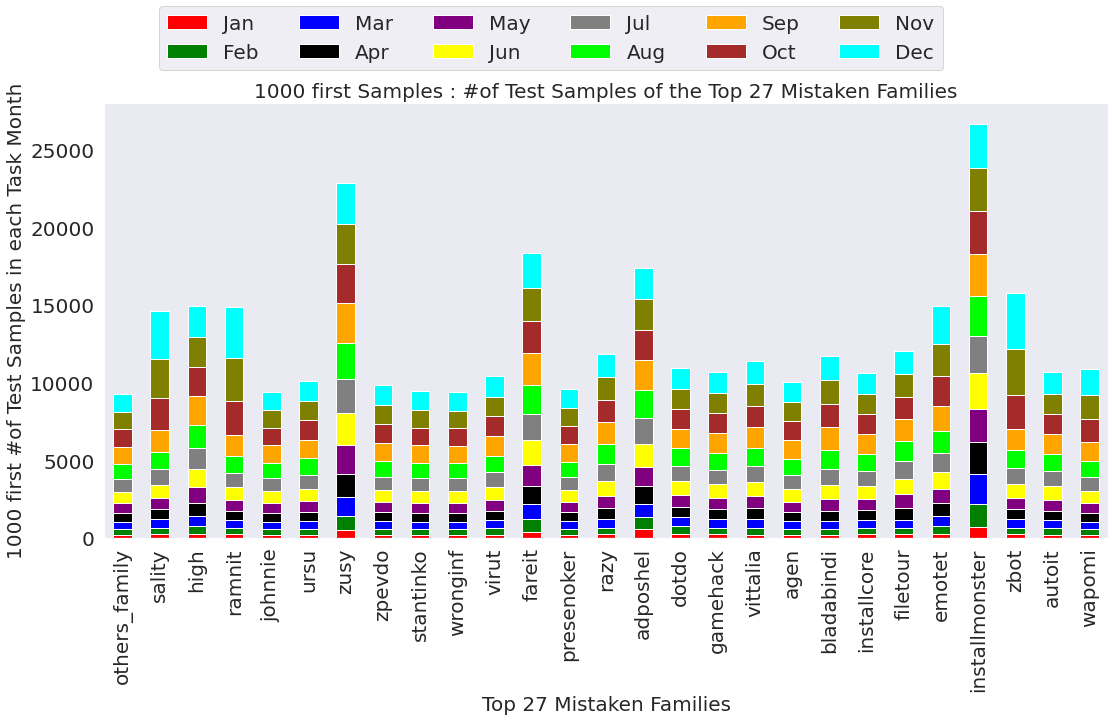

In [71]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

save_file_name = f'{num_samples_per_fam}_First_Test_Samples_with_Top_{len(top_mistaken_families)}_Mistaken_Families.png'


#sns.color_palette("rocket", as_cmap=True)
sns.set(rc={'figure.figsize':(18, 8)})


colors = ['red', 'green', 'blue', 'black', 'purple', 'yellow', 
          'gray', 'lime', 'orange', 'brown', 'olive', 'aqua']

# create DataFrame
df = pd.DataFrame(test_data_by_family,
                  index=top_mistaken_families)
sns.set_theme()
sns.set_style("dark")

df.plot(kind='bar', stacked=True, fontsize=20, color = colors)

plt.xlabel(f'Top {len(top_mistaken_families)} Mistaken Families', fontsize=20)
plt.ylabel(f'{num_samples_per_fam} first #of Test Samples in each Task Month', fontsize=20)
 
# title of plot
plt.title(f'{num_samples_per_fam} first Samples : #of Test Samples of the Top {len(top_mistaken_families)} Mistaken Families', fontsize=20)




plt.legend(ncol=6, loc=(.055, 1.075), fontsize=20)

#plt.grid(True, linestyle='--', linewidth=1.)
plt.savefig('./figures/' + save_file_name,
                bbox_inches='tight');

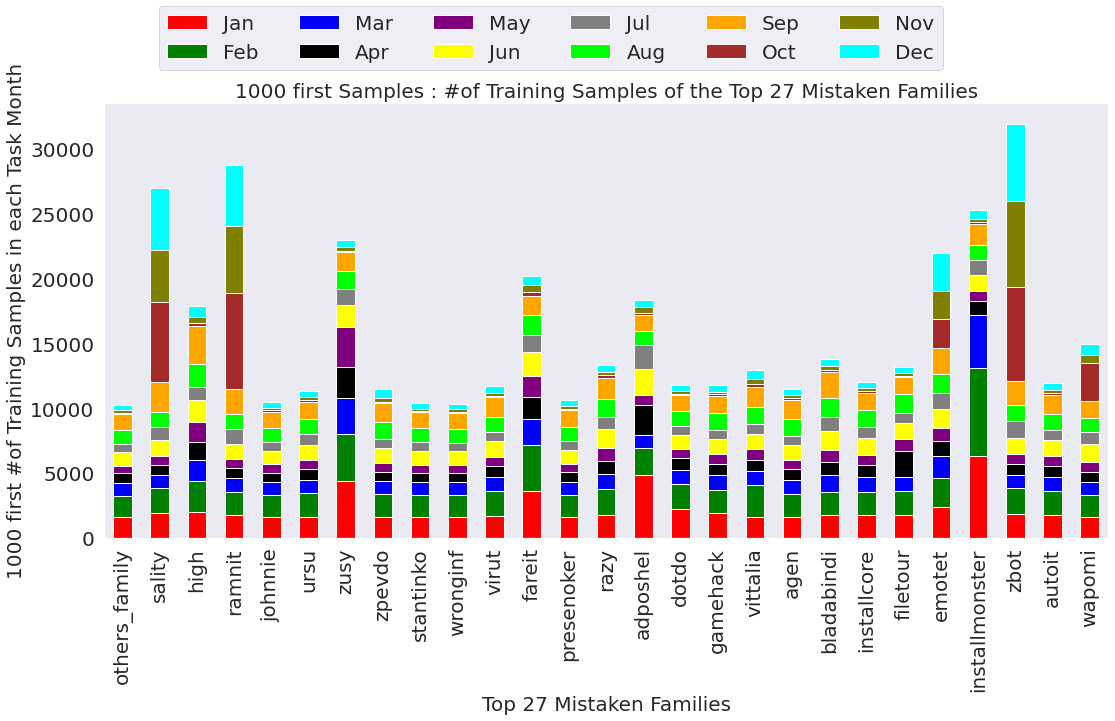

In [57]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

save_file_name = f'{num_samples_per_fam} First Training_Samples_with_Top_{len(top_mistaken_families)}_Mistaken_Families.png'


#sns.color_palette("rocket", as_cmap=True)
sns.set(rc={'figure.figsize':(18, 8)})


colors = ['red', 'green', 'blue', 'black', 'purple', 'yellow', 
          'gray', 'lime', 'orange', 'brown', 'olive', 'aqua']

# create DataFrame
df = pd.DataFrame(training_data_by_family,
                  index=top_mistaken_families)
sns.set_theme()
sns.set_style("dark")

df.plot(kind='bar', stacked=True, fontsize=20, color = colors)

plt.xlabel(f'Top {len(top_mistaken_families)} Mistaken Families', fontsize=20)
plt.ylabel(f'{num_samples_per_fam} first #of Training Samples in each Task Month', fontsize=20)
 
# title of plot
plt.title(f'{num_samples_per_fam} first Samples : #of Training Samples of the Top {len(top_mistaken_families)} Mistaken Families', fontsize=20)




plt.legend(ncol=6, loc=(.055, 1.075), fontsize=20)

#plt.grid(True, linestyle='--', linewidth=1.)
plt.savefig('./figures/' + save_file_name,
                bbox_inches='tight');

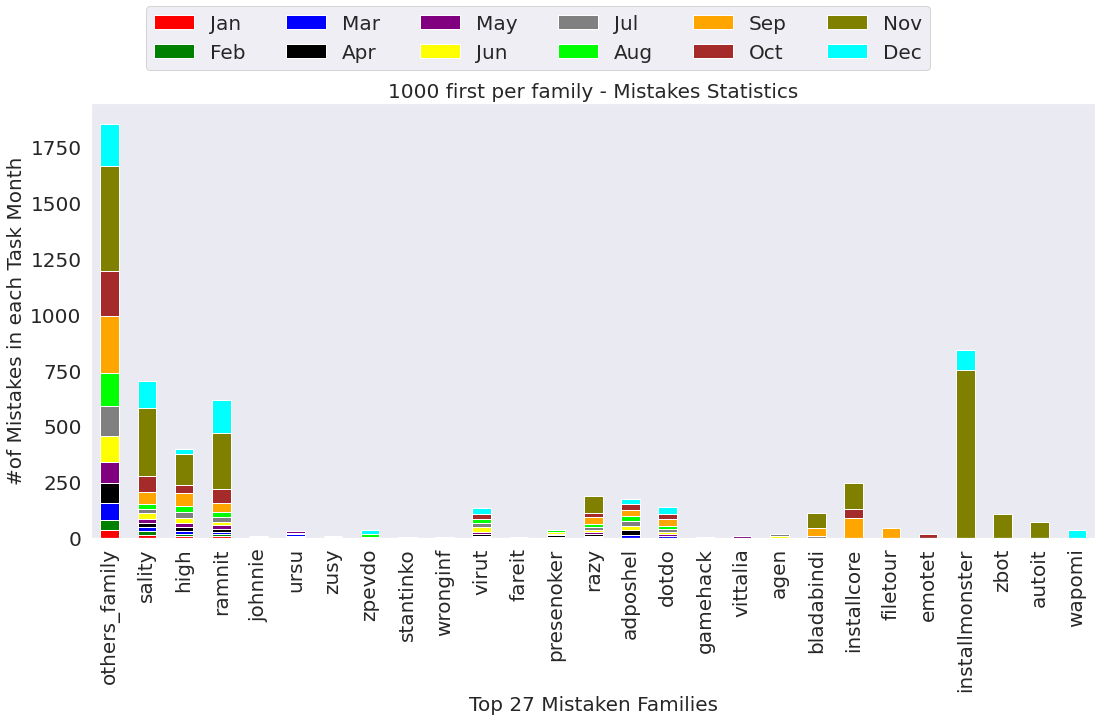

In [58]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

save_file_name = f'First_{num_samples_per_fam}_Mistakes_stats.png'


#sns.color_palette("rocket", as_cmap=True)
sns.set(rc={'figure.figsize':(18, 8)})


colors = ['red', 'green', 'blue', 'black', 'purple', 'yellow', 
          'gray', 'lime', 'orange', 'brown', 'olive', 'aqua']

# create DataFrame
df = pd.DataFrame(mistakes_data_by_family,
                  index=top_mistaken_families)
sns.set_theme()
sns.set_style("dark")

df.plot(kind='bar', stacked=True, fontsize=20, color = colors)

plt.xlabel(f'Top {len(top_mistaken_families)} Mistaken Families', fontsize=20)
plt.ylabel('#of Mistakes in each Task Month', fontsize=20)
 
# title of plot
plt.title(f'{num_samples_per_fam} first per family - Mistakes Statistics', fontsize=20)




plt.legend(ncol=6, loc=(.055, 1.075), fontsize=20)

#plt.grid(True, linestyle='--', linewidth=1.)
plt.savefig('./figures/' + save_file_name,
                bbox_inches='tight');

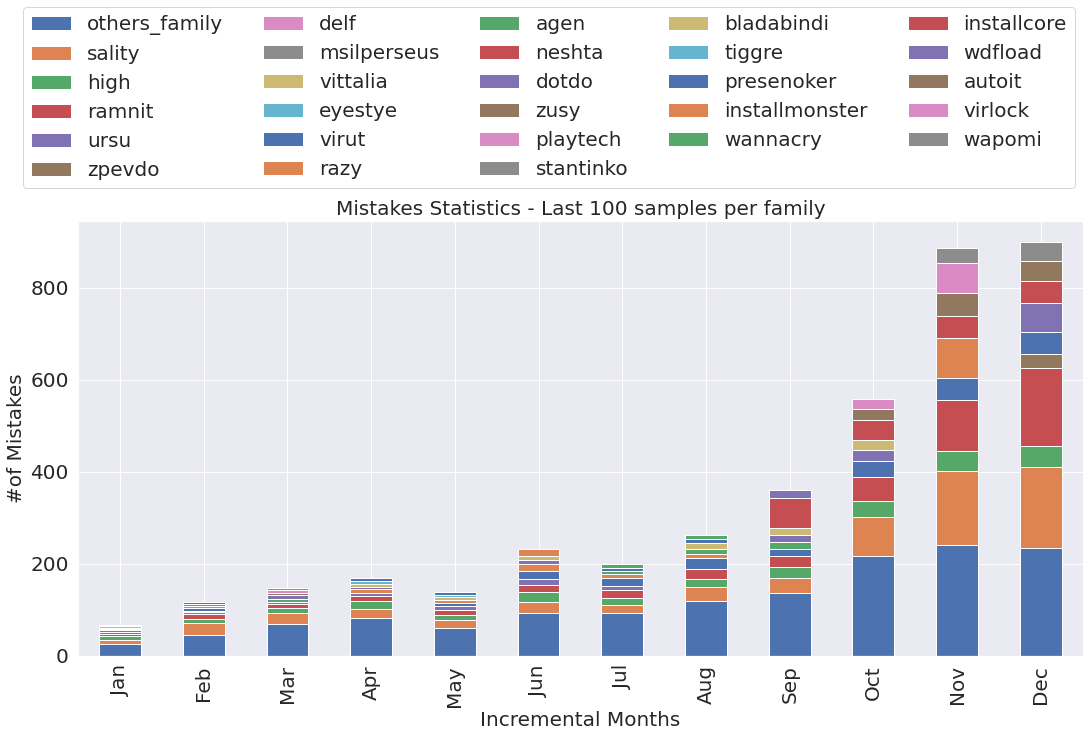

In [103]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(rc={'figure.figsize':(18, 8)})

# create DataFrame
df = pd.DataFrame(mistakes_data,
                  index=['Jan', 'Feb', 'Mar', 'Apr', 'May',
                         'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                         'Nov', 'Dec'])

df.plot(kind='bar', stacked=True, fontsize=20)

plt.xlabel('Incremental Months', fontsize=20)
plt.ylabel('#of Mistakes', fontsize=20)
 
# title of plot
plt.title('Mistakes Statistics - Last 100 samples per family', fontsize=20)

sns.set(style="whitegrid")
sns.color_palette("rocket", as_cmap=True)


plt.legend(ncol=5, loc=(-.055, 1.075), fontsize=20)